In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold,mutual_info_classif,SelectKBest,SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import  GridSearchCV,cross_val_score,TimeSeriesSplit,cross_validate

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score,roc_curve, auc,matthews_corrcoef
from sklearn.metrics import  make_scorer,accuracy_score,precision_score,recall_score, f1_score,brier_score_loss,matthews_corrcoef
from sklearn import tree

In [2]:
#reading csv files
X_train=pd.read_csv('X_train_F.csv')
Y_train=pd.read_csv('Y_train_F.csv')
X_test=pd.read_csv('X_test_F.csv')
Y_test=pd.read_csv('Y_test_F.csv')

In [3]:
X_train= X_train[:70000]
Y_train=Y_train[:70000]

In [4]:
#LGBM

In [5]:
import lightgbm as lgb

/Users/neenu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [6]:
clf = lgb.LGBMClassifier()
clf.fit(X_train,Y_train)

/Users/neenu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LGBMClassifier()

In [7]:
y_trainpredprobem=clf.predict_proba(X_train)
y_testpredprobem = clf.predict_proba(X_test)

In [8]:
#auc score with default values
print('auc of train with default parameter:',roc_auc_score(Y_train,y_trainpredprobem[:,1]))
print('auc of test with  default parameter:',roc_auc_score(Y_test,y_testpredprobem[:,1]))

auc of train with default parameter: 0.9799899935436396
auc of test with  default parameter: 0.837674637086019


In [9]:
#  parameters currently used
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [10]:
#GridSearchCV with timeseries

folds = TimeSeriesSplit(n_splits = 3)

model=lgb.LGBMClassifier(class_weight="balanced")
params = {"max_depth": [5,10,15],
              "learning_rate" : [0.1,0.15,0.3],
              "num_leaves": [32,150,200],
              "n_estimators": [500,700],
              'boost_from_average': [False],
               "random_state": [2]}

gs_lgbm = GridSearchCV(model, param_grid = params, cv = folds, scoring = 'roc_auc',verbose=10, n_jobs=-1)

In [11]:
gs_lgbm.fit(X_train,Y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  5.7min finished
/Users/neenu/opt/anaconda3/lib/python3.7/site-p

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=LGBMClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'boost_from_average': [False],
                         'learning_rate': [0.1, 0.15, 0.3],
                         'max_depth': [5, 10, 15], 'n_estimators': [500, 700],
                         'num_leaves': [32, 150, 200], 'random_state': [2]},
             scoring='roc_auc', verbose=10)

In [12]:
#Best parameters
gs_lgbm.best_params_

{'boost_from_average': False,
 'learning_rate': 0.1,
 'max_depth': 15,
 'n_estimators': 700,
 'num_leaves': 150,
 'random_state': 2}

In [14]:
best_lgbm= lgb.LGBMClassifier(boost_from_average=False, learning_rate=0.1, max_depth=15, n_estimators=700,
num_leaves=150,random_state=2,class_weight="balanced")
best_lgbm.fit(X_train, Y_train.values.ravel())

LGBMClassifier(boost_from_average=False, class_weight='balanced', max_depth=15,
               n_estimators=700, num_leaves=150, random_state=2)

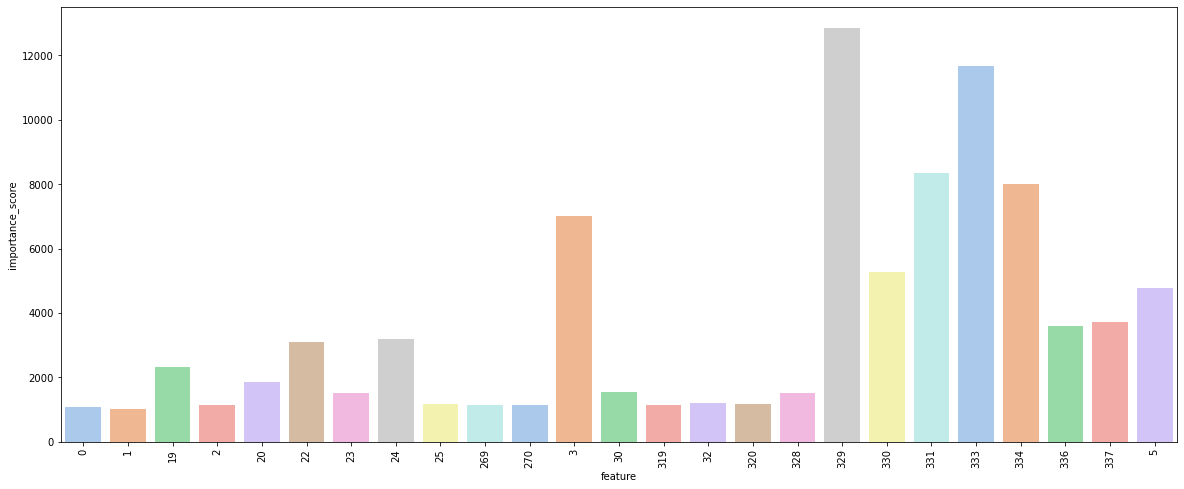

In [16]:
# visualize features with importantce score > 0
plt.figure(figsize=(20,8))
sorted_importance_lgb = sorted(zip(X_train.columns, best_lgbm.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_useful_lgb = [ i for i in sorted_importance_lgb if i[1] > 0]
a, b = zip(*sorted_importance_useful_lgb)
fp = pd.DataFrame({'feature':a, 'importance_score':b})[:25]
sns.barplot(x="feature", y="importance_score", data=fp, palette = 'pastel')
plt.xticks(rotation=90)
plt.show()

(array([3., 5., 8., 2., 2., 2., 3., 4., 5., 3., 0., 3., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([    0.  ,   128.69,   257.38,   386.07,   514.76,   643.45,
          772.14,   900.83,  1029.52,  1158.21,  1286.9 ,  1415.59,
         1544.28,  1672.97,  1801.66,  1930.35,  2059.04,  2187.73,
         2316.42,  2445.11,  2573.8 ,  2702.49,  2831.18,  2959.87,
         3088.56,  3217.25,  3345.94,  3474.63,  3603.32,  3732.01,
         3860.7 ,  3989.39,  4118.08,  4246.77,  4375.46,  4504.15,
         4632.84,  4761.53,  4890.22,  5018.91,  5147.6 ,  5276.29,
         5404.98,  5533.67,  5662.36,  5791.05,  5919.74,  6048.43,
      

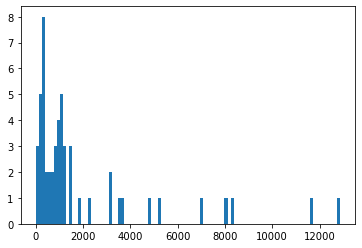

In [17]:
plt.hist(best_lgbm.feature_importances_,bins=100)

In [44]:
features = X_train.columns
importances = best_lgbm.feature_importances_
features_to_include=[]
j=0
for i in importances:
    if i>=1500:
        features_to_include.append(features[j])
    j+=1

In [45]:
X_trainlgbm=X_train[features_to_include]
X_testlgbm=X_test[features_to_include]

In [50]:
#test prediction with best parameters
best_lgbm= lgb.LGBMClassifier(boost_from_average=False, learning_rate=0.1, max_depth=15, n_estimators=700,
num_leaves=150,random_state=2)
best_lgbm.fit(X_train, Y_train.values.ravel())
y_trainpredbest =best_lgbm.predict_proba(X_train)
y_testpredbest =best_lgbm.predict_proba(X_test)
print('roc_auc:',roc_auc_score(Y_test,y_testpredbest[:,1]))
print('brier_score_loss:',brier_score_loss(Y_test,y_testpredbest[:,1]))

roc_auc: 0.8096096142707581
brier_score_loss: 0.029960942268771686


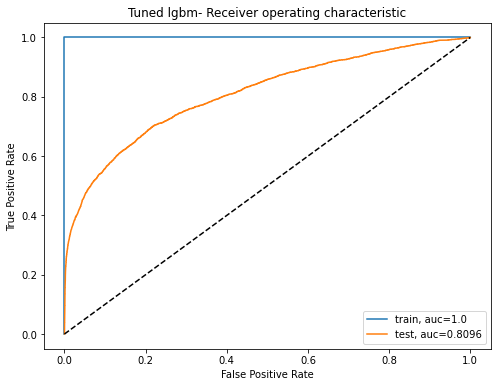

In [51]:
plt.figure(figsize=(8,6))
# auc of train
fpr, tpr, thresh = roc_curve(Y_train,y_trainpredbest[:,1])
auc = roc_auc_score(Y_train, y_trainpredbest[:,1])
plt.plot(fpr,tpr,label="train, auc="+str(round(auc,4)))
# auc of test
fpr, tpr, thresh = roc_curve(Y_test, y_testpredbest[:,1])
auc = roc_auc_score(Y_test,  y_testpredbest[:,1])
plt.plot(fpr,tpr,label="test, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned lgbm- Receiver operating characteristic')
plt.show()

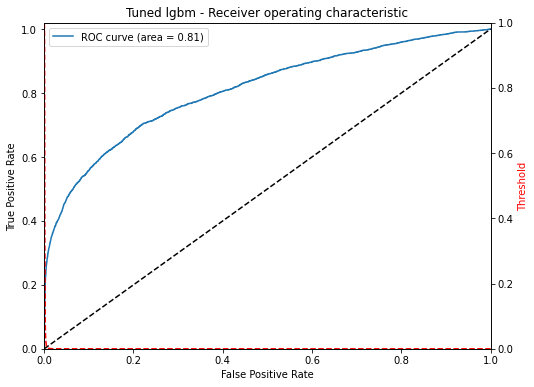

In [52]:
y_scores = y_testpredbest[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
# auc(fpr, tpr) # auc has been assigned as a variable by the above plot's code
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned lgbm - Receiver operating characteristic')
plt.legend(loc="best")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],1])
ax2.set_xlim([fpr[0],fpr[-1]])
plt.show()
# plt.axhline(y=0.0, c="r", ls="--", lw=2)
# plt.axvline(x=4.0, c="r", ls="--", lw=2)

In [54]:
y_testpred_ =best_lgbm.predict(X_test)
print("matthews_corrcoef:\n",matthews_corrcoef(Y_test, y_testpred_))
print("Recall:\n",metrics.recall_score(Y_test,y_testpred_))

matthews_corrcoef:
 0.33772609158586936
Recall:
 0.14868336544637123
